<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/hssm.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(ddm-notebook)=
# Drift Diffusion Model

Nei capitoli precedenti, abbiamo affrontato l'analisi bayesiana dei dati, esplorando questioni inferenziali legate sia alle relazioni tra variabili, sia alle caratteristiche di specifiche distribuzioni. In questo capitolo, ci dedicheremo allo studio di un esempio di modellizzazione cognitiva bayesiana, approfondendo come l'approccio bayesiano possa essere impiegato per articolare in maniera formale i processi causali che sottendono i fenomeni cognitivi.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az  
import pymc as pm
import pymc.sampling_jax
import hssm
from ssms.basic_simulators import simulator

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


ModuleNotFoundError: No module named 'hssm'

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

## Modellizzazione cognitiva bayesiana

Negli anni recenti, il panorama della ricerca psicologica è stato profondamente influenzato dalla cosiddetta "rivoluzione bayesiana". Questo movimento ha reso gli strumenti e le metodologie basate sull'inferenza bayesiana accessibili a un numero sempre maggiore di psicologi, arricchendo significativamente il campo con nuove prospettive e tecniche di analisi (S. P. Brooks, 2003; Andrews & Baguley, 2013; van de Schoot et al., 2017).

All'interno di questo contesto, i modelli lineari bayesiani hanno trovato un'ampia applicazione, diventando uno standard in molti ambiti della ricerca psicologica. L'utilizzo dell'inferenza bayesiana nella ricerca psicologica non si limita però all'analisi dei dati: essa apre infatti la porta a un ventaglio più ampio di opportunità. Un esempio è rappresentato dalla modellazione cognitiva bayesiana e dalla psichiatria computazionale, settori emergenti che impiegano principi bayesiani per formulare modelli formali dei processi cognitivi (Lee & Wagenmakers, 2013). Questi modelli, offrendo rappresentazioni formali e testabili scientificamente dei meccanismi psicologici che stanno alla base dei comportamenti osservati, contribuiscono a affinare la nostra comprensione delle complesse dinamiche cognitive che li governano (Navarro, 2021). Grazie a questo approccio, è possibile sondare in maniera più approfondita le relazioni causali e le interdipendenze presenti nei fenomeni psicologici.

Nel proseguo di questo capitolo approfondiremo un modello cognitivo bayesiano molto noto: il Drift Diffusion Model, strumento analitico di fondamentale importanza nel campo della psichiatria computazionale.

## Il modello dei tempi di reazione

Il Drift Diffusion Model (DDM) è un modello computazionale ampiamente utilizzato per analizzare i dati sui tempi di reazione e le scelte in compiti di decisione binaria. Originariamente derivato dalla teoria delle decisioni sequenziali, il DDM fornisce un quadro per comprendere come le decisioni vengano prese in situazioni di incertezza e sotto vincoli temporali. Il modello è particolarmente utile per esaminare il processo di accumulo di informazioni verso una delle due possibili scelte o "barriere decisionali".

### Parametri del Modello

1. **Drift Rate (v)**: Il drift rate rappresenta la velocità con cui le informazioni vengono accumulate nel corso del tempo verso una delle due barriere decisionali. Un drift rate elevato suggerisce una raccolta rapida delle informazioni, mentre un drift rate basso indica un processo più lento. Il segno del drift rate indica la direzione della decisione. Un drift rate positivo suggerisce che le informazioni stanno accumulandosi a favore della barriera superiore (o di una delle due scelte), mentre un drift rate negativo indica l'opposto.

2. **Boundary Separation (a)**: Questo parametro indica la distanza tra le due barriere decisionali. Una separazione maggiore implica che è necessario accumulare più informazioni per prendere una decisione, il che di solito si traduce in tempi di reazione più lunghi ma decisioni potenzialmente più accurate. Una separazione minore, al contrario, può portare a decisioni più rapide ma potenzialmente meno accurate.

3. **Non-Decision Time (t)**: Questo è il tempo impiegato per processi non decisionali, come la percezione sensoriale e l'esecuzione motoria. Esso rappresenta il ritardo temporale che precede l'inizio dell'accumulo delle informazioni e segue la raggiungimento della decisione, prima dell'effettiva risposta comportamentale.

4. **A Priori Decision Bias (z)**: Questo parametro rappresenta il punto di partenza dell'accumulo delle informazioni. In un modello simmetrico, questo valore è tipicamente impostato a metà della separazione delle barriere (a/2), indicando l'assenza di un pregiudizio iniziale. Tuttavia, se c'è un pregiudizio a priori verso una delle due scelte, il punto di partenza sarà spostato più vicino a quella barriera.

### Funzionamento del Modello

Nel Drift Diffusion Model, si assume che un processo di decisione inizi dal punto di partenza \( z \) e che le informazioni siano accumulate nel tempo con una velocità \( v \) fino a raggiungere una delle due barriere decisionali separate da \( a \). Il tempo necessario per raggiungere una delle due barriere, sommato al tempo non decisionale \( t \), fornirà il tempo di reazione totale per quella decisione specifica.

### Applicazioni e Limitazioni

Il DDM è ampiamente utilizzato in psicologia cognitiva, neuroscienze e economia comportamentale. Esso permette di dissociare diversi processi coinvolti nella presa di decisione e offre intuizioni su come i diversi parametri possano essere influenzati da variabili come l'età, l'attenzione, e le condizioni sperimentali.

Tuttavia, il modello ha alcune limitazioni. Ad esempio, è ottimizzato per decisioni binarie e può non adattarsi bene a contesti decisionali più complessi. Inoltre, come per qualsiasi modello, la sua validità dipende dalla qualità del fit ai dati e dalla generalizzabilità a diversi contesti e popolazioni.

In sintesi, il Drift Diffusion Model offre un potente strumento per lo studio dettagliato dei processi decisionali, fornendo sia una spiegazione meccanicistica che la capacità di effettuare predizioni quantitative.

## Simulazioni e stima 

Il fine della sezione seguente è illustrare il processo di stima dei parametri del Drift Diffusion Model (DDM) attraverso l'utilizzo della libreria PyMC.

Innanzitutto, procediamo con la simulazione dei dati. Immaginiamo che un individuo sottoposto a test completi 200 tentativi in un esercizio di decisione binaria. Le istruzioni che seguono servono per generare un set di dati simulati, basati sul meccanismo generativo corrispondente al DDM, utilizzando i parametri specificati di seguito.

In [3]:
# Specify parameters
v_true, a_true, z_true, t_true = [1.5, 0.75, 0.5, 0.15]

# Simulate data
sim_out = simulator(
    theta=[v_true, a_true, z_true, t_true],  # parameter list
    model="ddm",  # specify model (many are included in ssms)
    n_samples=200,  # number of samples for each set of parameters
)

# Turn into nice dataset
# Turn data into a pandas dataframe
dataset = pd.DataFrame(
    np.column_stack([sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
    columns=["rt", "response"],
)

dataset

,rt,response
0,0.471999,1.0
1,0.501999,1.0
2,0.487999,1.0
3,0.600998,1.0
4,1.715017,1.0
...,...,...
195,0.426000,1.0
196,0.730996,1.0
197,0.319000,1.0
198,0.635997,-1.0


I parametri del modello si possono stimare dai dati usando PyMC. Per ciascun parametro possiamo specificare la distribuzione a priori. Nel caso presente, usiamo quelle indicate di seguito.

In [4]:
with pm.Model() as ddm_pymc:
    v = pm.Normal("v", mu=0, sigma=4.0)
    a = pm.HalfNormal("a", sigma=2.0)
    z = pm.Uniform("z", lower= 0.0, upper= 1.0)
    t = pm.Uniform("t", lower=0.0, upper=0.6, initval=0.1)
    
    ddm = hssm.likelihoods.DDM("DDM", v=v, a=a, z=z, t=t, observed=dataset.values)

L'aspetto cruciale del modello PyMC è rappresentata dalla versomiglianza del modello DDM, `hssm.likelihoods.DDM`, la quale è specificata dalla funzione `DDM` del pacchetto `hssm`.

Per informazioni sull'installazione di `hssm`, si veda il [sito dedicato](https://lnccbrown.github.io/HSSM/).

``````{note}
È consigliabile installare `hssm` in un ambiente virtuale dedicato, oppure usarlo su Colab, inquanto può interferire con i pacchetti dell'ambiente virtuale che usiamo per le altre analisi statistiche di questo corso.

Per installare `hssm` sul mio computer ho usato la procesura seguente.

```bash
conda create -c conda-forge -n hssm_env "pymc==5.7.2"
conda activate hssm_env
```

```bash
conda install numpyro
conda install blackjax
conda install -c conda-forge bambi
conda install -c conda-forge seaborn
pip install hssm
pip install aquarel
```
``````

In [5]:
ddm_pymc

  v ~ Normal(0, 4)
  a ~ HalfNormal(0, 2)
  z ~ Uniform(0, 1)
  t ~ Uniform(0, 0.6)
DDM ~ SSM(v, a, z, t)

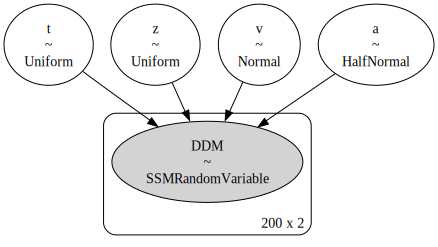

In [6]:
pm.model_to_graphviz(model=ddm_pymc)

Eseguiamo il campionamento.

In [7]:
with ddm_pymc:
    ddm_pymc_trace = pm.sampling_jax.sample_numpyro_nuts(draws=2000, tune=1000)

Compiling...
Compilation time =  0:01:48.238677
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]







Running chain 0:   5%|▌         | 150/3000 [00:07<00:10, 260.49it/s]


Running chain 0:  10%|█         | 300/3000 [00:08<00:09, 296.25it/s]


Running chain 0:  15%|█▌        | 450/3000 [00:08<00:09, 270.38it/s]


Running chain 0:  20%|██        | 600/3000 [00:09<00:09, 245.01it/s]


Running chain 0:  25%|██▌       | 750/3000 [00:10<00:08, 276.67it/s]


Running chain 0:  30%|███       | 900/3000 [00:10<00:06, 327.90it/s]


Running chain 0:  35%|███▌      | 1050/3000 [00:10<00:06, 306.63it/s]


Running chain 0:  40%|████      | 1200/3000 [00:11<00:06, 293.82it/s]


Running chain 0:  45%|████▌     | 1350/3000 [00:12<00:06, 256.84it/s]


Running chain 0:  50%|█████     | 1500/3000 [00:12<00:05, 264.54it/s]



Running chain 0:  55%|█████▌    | 1650/3000 [00:13<00:04, 278.59it/s]


Running chain 0:  60%|██████    | 1800/3000 [00:13<00:04, 264.39it/s]


Running chain 0:  65%|██████▌   | 1950/3000 [00:14<00:04, 252.24it/s]


Running

Sampling time =  0:00:19.822851
Transforming variables...
Transformation time =  0:00:00.087737


In [56]:
# simple_ddm_model = hssm.HSSM(data=dataset)
# print(simple_ddm_model)

Otteniamo in questo modo un oggetto `idata` come abbiamo visto in precedenza.

In [8]:
ddm_pymc_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

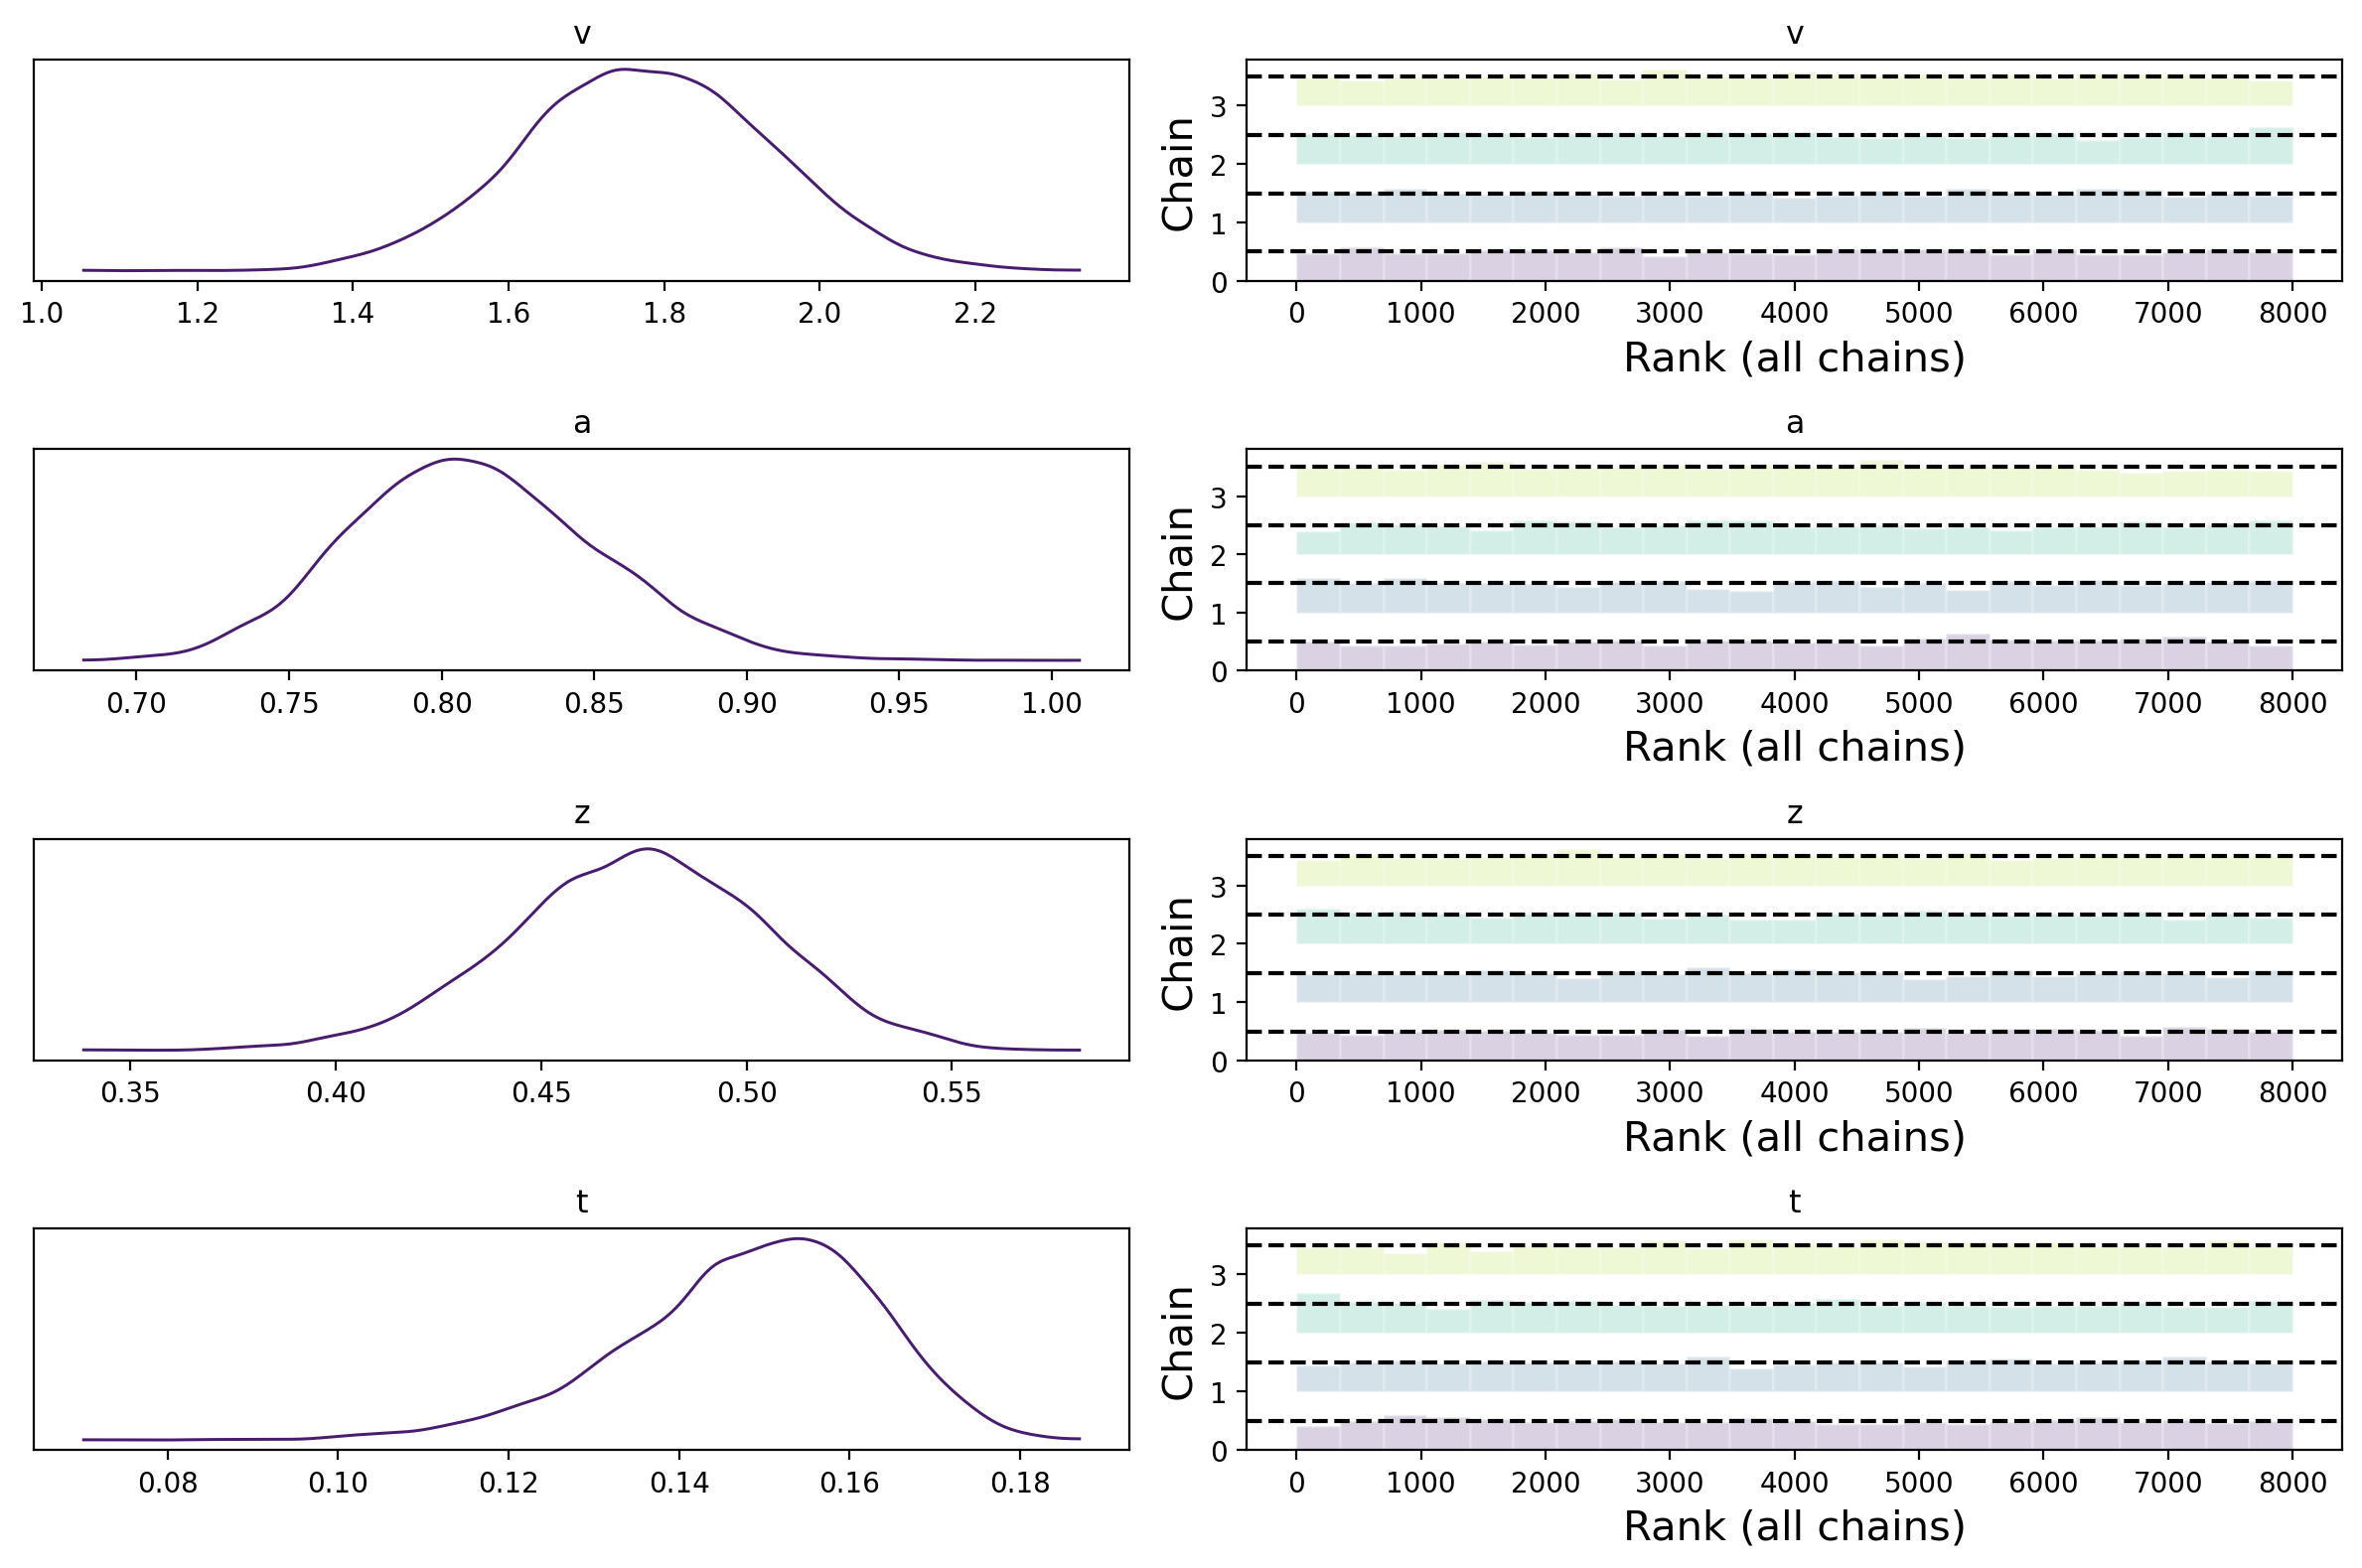

In [10]:
az.plot_trace(ddm_pymc_trace, combined=True, kind="rank_bars")
plt.tight_layout()
plt.show()

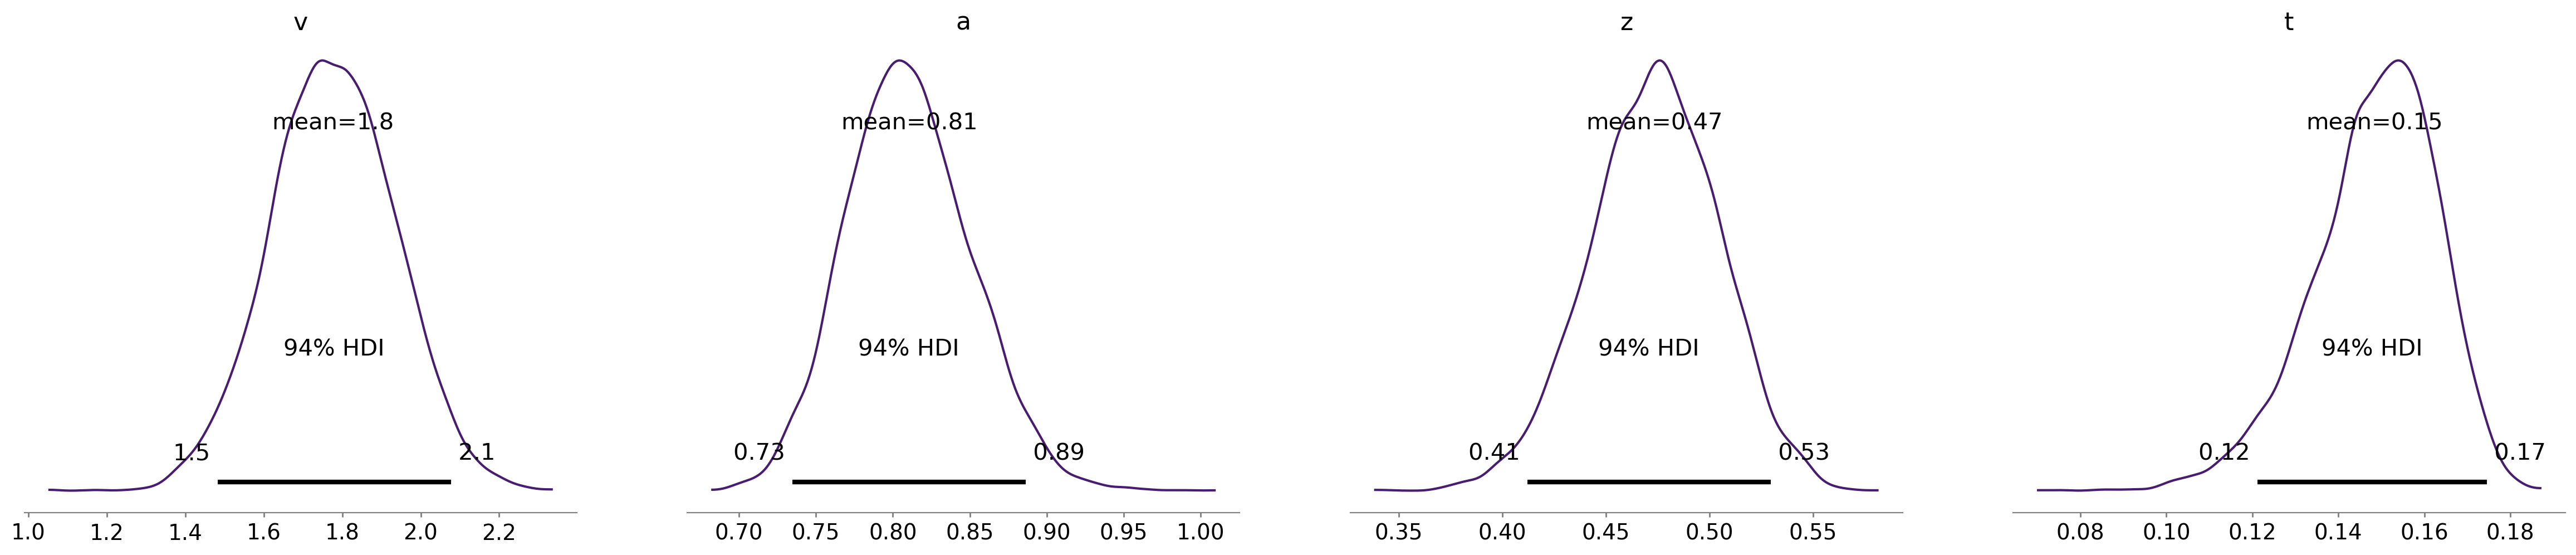

In [13]:
az.plot_posterior(ddm_pymc_trace);

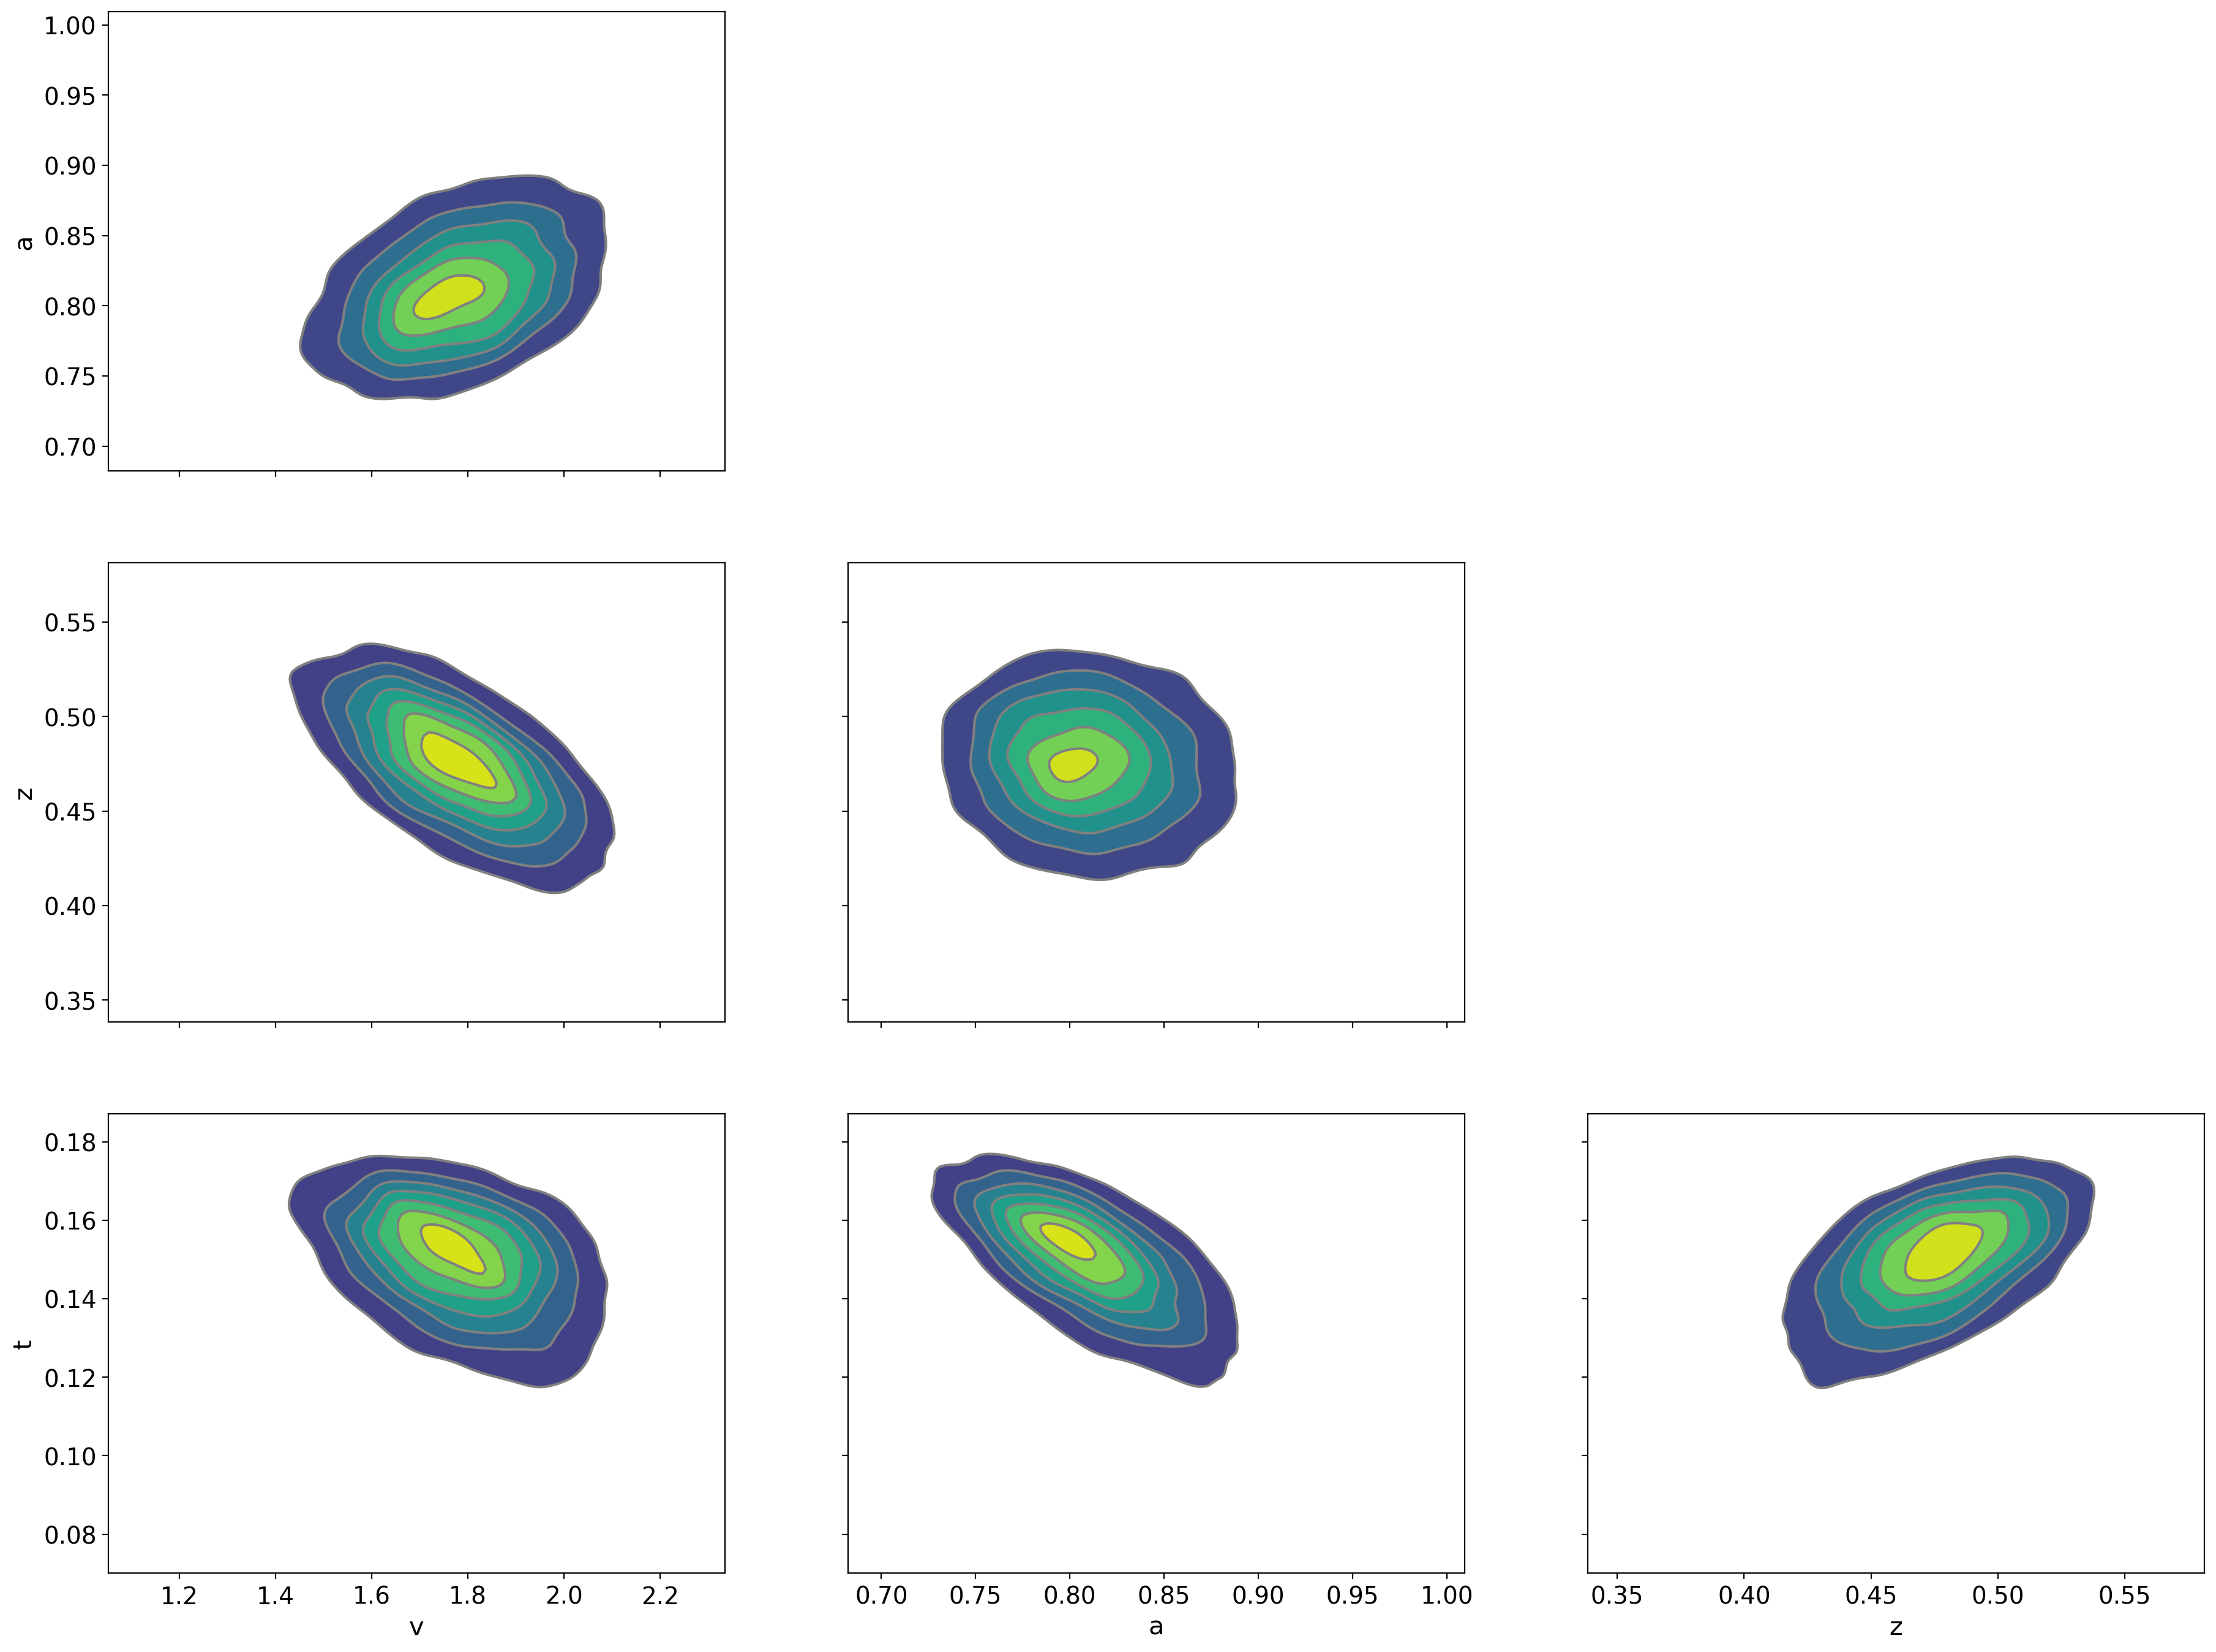

In [14]:
az.plot_pair(ddm_pymc_trace, kind="kde")
plt.show()

In [15]:
az.summary(ddm_pymc_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,1.776,0.159,1.482,2.077,0.003,0.002,3589.0,4176.0,1.0
a,0.811,0.041,0.735,0.886,0.001,0.001,3210.0,3913.0,1.0
z,0.473,0.031,0.412,0.529,0.001,0.000,3024.0,3696.0,1.0
t,0.148,0.015,0.121,0.175,0.000,0.000,3078.0,3410.0,1.0


Si noti che, con solo 200 osservazioni per soggetto, è stato possibile recuperare con una buona precisione i valore dei parametri del modello DDM usati per simulare i dati.